In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pickle
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from concurrent.futures import ProcessPoolExecutor
from prices import full_dates, will_increase, prices, h_corr, f_corr
from embeddings import get_embeddings1d_da_noda, get_embeddings_da_noda, get_embeddings_noda, to_cos_matrix
from helpers import load_pickle, save_pickle, convert_level0dates_to_str, flatten_square_df, to_sorted_dates_index, dropnas
from metrics import compute_metrics, avg_rk_mse, filter_top_hst_correl, filter_top_hst_correl_ptck
n_features = 384

c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
ticker_to_name = {'AAPL': 'Apple', 'TSLA': 'Tesla', 'MSFT': 'Microsoft', 'CVX': 'Chevron', 'AMZN': 'Amazon', 'JPM': 'JPMorgan'}

def get_pos_twt(ticker):
    ticker = ticker_to_name.get(ticker, ticker)
    return [f'{ticker} is underrated imo.', f'{ticker} is the best stock!', f'I love {ticker}!']

def get_pos_twt_CEO(ticker):
    ticker = ticker_to_name.get(ticker, ticker)
    return get_pos_twt(ticker)
    return [f"{ticker}'s CEO is a legend.", f'Since {ticker} has a new CEO, the company has evolved.', f"Elon Musk is not as smart as {ticker}'s CEO"]

def get_neu_twt(ticker):
    ticker = ticker_to_name.get(ticker, ticker)
    return [f"Wonder why {ticker} has opened a new store in Paris. Any thoughts?", f"Exclusive offer: join {ticker} on our webpage https://pandas.pydata.org"]

def get_neg_twt(ticker):
    ticker = ticker_to_name.get(ticker, ticker)
    return [f'{ticker} is overrated imo.', f'Why is everyone buying {ticker}? Not sure how future-proof it is.', f'I hate {ticker}!']

def get_neg_twt_CEO(ticker):
    ticker = ticker_to_name.get(ticker, ticker)
    return [f"{ticker}'s CEO is quite average.", f'Since {ticker} has a new CEO, the company has collapsed.', f"Elon Musk is a lot smarter than {ticker}'s CEO. No wonder why the stock is performing so poorly compared to Tesla."]

tickers = prices.columns.to_list()
ticker_to_tweets = {ticker: {'pos': get_pos_twt(ticker) + get_pos_twt_CEO(ticker), 'neu': get_neu_twt(ticker), 'neg': get_neg_twt(ticker) + get_neg_twt_CEO(ticker)} for ticker in tickers}


proba_distrib = {
    True: [0.7, 0.2, 0.1], # positive, neutral, negative
    False: [0.1, 0.15, 0.75],
    # False: [0.9, 0.05, 0.05],
    # True: [0.95, 0., 0.05],
}

def get_twts_one_day(day, wid: pd.Series):
    twts = []
    for ticker, wi in wid.items():
        num_tweets = np.random.randint(0, 5)  # Number of tweets is random between 0 and 4
        probabilities = proba_distrib[wi]
        for _ in range(num_tweets):
            sentiment = np.random.choice(['pos', 'neu', 'neg'], p=probabilities)
            tweet = np.random.choice(ticker_to_tweets[ticker][sentiment])
            twts.append({
                'Date': day,
                'Ticker': ticker,
                'Body': tweet,
                'Sentiment': sentiment
            })
    return pd.DataFrame(twts)

def generate_and_save_dataset():
    dataset = []
    for day in tqdm(full_dates):
        dataset.append(get_twts_one_day(day, will_increase.loc[day]))
    dataset = pd.concat(dataset)

    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    embeddings = pd.DataFrame(model.encode(dataset['Body'].to_list(), batch_size=32), index=dataset.index)
    dataset = pd.concat((dataset, embeddings), axis=1)
    dataset.to_parquet('dataset.pq')
    return dataset

def load_dataset():
    try:
        return pd.read_parquet('dataset.pq')
    except:
        return generate_and_save_dataset()

In [3]:
dataset = generate_and_save_dataset()

100%|██████████| 1492/1492 [00:01<00:00, 1054.40it/s]
c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\pandas\io\parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [3]:
dataset = load_dataset()

In [5]:
dataset.head(30)

,Date,Ticker,Body,Sentiment,0,1,2,3,4,5,...,374,375,376,377,378,379,380,381,382,383
0,2017-11-02,AAPL,Apple is the best stock!,pos,0.003024,-0.037076,0.030828,-0.028224,-0.024417,0.030946,...,-0.006862,-0.003800,-0.035751,-0.079862,-0.045213,0.041173,0.087646,-0.094929,0.067767,0.100663
1,2017-11-02,AMZN,Amazon is the best stock!,pos,0.001394,-0.063670,-0.044535,0.016367,-0.015406,0.042147,...,0.017995,0.002100,-0.021207,-0.047008,-0.024498,0.030409,0.038037,-0.114195,0.013863,0.092744
2,2017-11-02,AMZN,Amazon is underrated imo.,pos,-0.039775,-0.067308,-0.062510,-0.004664,0.035826,-0.004069,...,0.044620,-0.024272,0.033583,-0.046541,-0.046288,0.124546,0.034451,-0.118923,0.040205,0.074185
3,2017-11-02,CVX,I love Chevron!,pos,-0.086330,0.014445,0.057959,-0.000897,-0.049280,-0.041090,...,0.007190,0.001663,-0.039614,-0.010750,-0.024442,0.019398,0.073311,-0.026225,0.072381,-0.044283
4,2017-11-02,CVX,I love Chevron!,pos,-0.086330,0.014445,0.057959,-0.000897,-0.049280,-0.041090,...,0.007190,0.001663,-0.039614,-0.010750,-0.024442,0.019398,0.073311,-0.026225,0.072381,-0.044283
5,2017-11-02,MSFT,Exclusive offer: join Microsoft on our webpage...,neu,-0.039019,-0.054168,-0.033279,0.019359,0.025785,-0.011796,...,-0.011239,0.010792,-0.026173,0.040853,0.043714,0.087886,0.059822,-0.065415,0.000664,0.035858
6,2017-11-02,TSLA,Tesla is underrated imo.,pos,-0.061040,-0.000139,0.010584,0.012097,-0.017304,-0.002238,...,0.009516,0.039596,-0.047628,0.004802,-0.089271,-0.022504,0.045935,-0.043472,0.075117,0.073693
7,2017-11-02,TSLA,Exclusive offer: join Tesla on our webpage htt...,neu,-0.071224,-0.018937,-0.023684,0.037557,-0.006532,-0.037920,...,0.002526,0.037011,-0.086653,0.064307,0.026185,-0.032366,0.113055,-0.081338,-0.013883,0.065651
8,2017-11-02,TSLA,Tesla is the best stock!,pos,-0.035908,-0.004290,0.007337,-0.006009,-0.056251,0.027041,...,0.010903,0.024551,-0.073929,-0.000801,-0.054821,-0.040635,0.074032,-0.062105,0.070701,0.110285
9,2017-11-02,TSLA,Tesla is underrated imo.,pos,-0.061040,-0.000139,0.010584,0.012097,-0.017304,-0.002238,...,0.009516,0.039596,-0.047628,0.004802,-0.089271,-0.022504,0.045935,-0.043472,0.075117,0.073693


In [6]:
embeddings_1d_das = []
for day in tqdm(dataset['Date'].unique()):
    embeddings_1d: pd.DataFrame = dataset[dataset['Date']==day].copy()
    embeddings_1d['clean_id_qis'] = embeddings_1d['Ticker']
    embeddings_1d['date'] = embeddings_1d['Date']
    embeddings_1d.drop(['Date', 'Ticker', 'Body', 'Sentiment'], axis=1, inplace=True)
    embeddings_1d_das.append(get_embeddings1d_da_noda(embeddings_1d, n_features=n_features))
embeddings_da = get_embeddings_da_noda(embeddings_1d_das, n_features=n_features)
embeddings = convert_level0dates_to_str(get_embeddings_noda(embeddings_da, window='7D', n_features=n_features))
h_corr = convert_level0dates_to_str(h_corr)
f_corr = convert_level0dates_to_str(f_corr)


100%|██████████| 1492/1492 [00:07<00:00, 202.44it/s]


In [52]:
def compute_pair_to_idx(tickers_d, mask, i_indices, j_indices):
    i_indices = i_indices[mask]
    j_indices = j_indices[mask]
    pairs = list(zip(tickers_d[i_indices], tickers_d[j_indices]))
    df = pd.DataFrame({'idx_i': i_indices, 'idx_j': j_indices}, index=pd.MultiIndex.from_tuples(pairs))
    pair_to_idx = df.apply(tuple, axis=1).to_dict()
    return pair_to_idx

In [113]:
dates = embeddings.index.get_level_values(0).unique().intersection(f_corr.index.get_level_values(0).unique())
dict_e = {}
dict_h_corr = {}
dict_f_corr = {}
dict_pairs = {}
dict_mask = {}
dict_id_qi_to_idx = {}

for day in tqdm(dates):
    emb_d: pd.DataFrame = embeddings.loc[day]
    h_corr_d: pd.DataFrame  = h_corr.loc[day]
    f_corr_d : pd.DataFrame = f_corr.loc[day]
    intersection_tickers = np.array(sorted(list(emb_d.index.intersection(f_corr_d.index).intersection(h_corr_d.index)))) # important to sort here
    if len(intersection_tickers) <= 1:
        print(f"{day}: Only {len(intersection_tickers)} ticker! Will be removed from the dataset.")
        continue
    dict_e[day] = emb_d.loc[intersection_tickers]
    dict_f_corr[day] = f_corr_d.loc[intersection_tickers, intersection_tickers]
    dict_h_corr[day] = h_corr_d.loc[intersection_tickers, intersection_tickers]
    mask, i_indices, j_indices = filter_top_hst_correl(dict_h_corr[day], r=0.3, return_indices=True)
    (i_indices_2, j_indices_2) = np.triu_indices(len(intersection_tickers), k=1)
    assert np.all(i_indices==i_indices_2)
    assert np.all(j_indices==j_indices_2)
    dict_pairs[day] = pd.Series(True, index=np.array(list(zip(intersection_tickers[i_indices], intersection_tickers[j_indices])))[mask])
    dict_id_qi_to_idx[day] = dict(zip(intersection_tickers.tolist(), np.arange(len(intersection_tickers))))

save_pickle(dict_e, "./dict", "embeddings.pk")
save_pickle(dict_h_corr, "./dict", "h_corr.pk")
save_pickle(dict_f_corr, "./dict", "f_corr.pk")
save_pickle(dict_pairs, "./dict", "pairs.pk")
save_pickle(dict_id_qi_to_idx, "./dict", "id_qi_to_idx.pk")

  0%|          | 0/1028 [00:00<?, ?it/s]

 61%|██████    | 629/1028 [00:01<00:01, 368.71it/s]

2020-01-31: Only 1 ticker! Will be removed from the dataset.


100%|██████████| 1028/1028 [00:03<00:00, 329.17it/s]


Saved file at ./dict/embeddings.pk
Saved file at ./dict/h_corr.pk
Saved file at ./dict/f_corr.pk
Saved file at ./dict/pairs.pk
Saved file at ./dict/id_qi_to_idx.pk


In [136]:
seq_length = 5
start_date = '2017-12-01'
end_date = '2018-10-31'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
dict_pairs_period = {
    day: v for day, v in dict_pairs.items()
    if start_date_dt <= datetime.strptime(day, '%Y-%m-%d') <= end_date_dt
}
dict_pairs_period

{'2017-12-01': (AMZN, TSLA)    True
 dtype: bool,
 '2017-12-04': (AAPL, AMZN)    True
 (AAPL, MSFT)    True
 (AAPL, TSLA)    True
 (AMZN, MSFT)    True
 (CVX, JPM)      True
 dtype: bool,
 '2017-12-05': (AAPL, AMZN)    True
 (AAPL, MSFT)    True
 (AAPL, TSLA)    True
 (AMZN, MSFT)    True
 (CVX, JPM)      True
 dtype: bool,
 '2017-12-06': (AAPL, AMZN)    True
 (AAPL, TSLA)    True
 (CVX, JPM)      True
 dtype: bool,
 '2017-12-07': (AMZN, MSFT)    True
 (CVX, TSLA)     True
 dtype: bool,
 '2017-12-08': (AAPL, AMZN)    True
 (AMZN, MSFT)    True
 dtype: bool,
 '2017-12-11': (AAPL, AMZN)    True
 (AAPL, MSFT)    True
 (AAPL, TSLA)    True
 (AMZN, MSFT)    True
 (CVX, JPM)      True
 dtype: bool,
 '2017-12-12': (AAPL, AMZN)    True
 (AAPL, TSLA)    True
 dtype: bool,
 '2017-12-13': (AAPL, AMZN)    True
 (AAPL, MSFT)    True
 (AAPL, TSLA)    True
 (AMZN, MSFT)    True
 (CVX, JPM)      True
 dtype: bool,
 '2017-12-14': (CVX, JPM)    True
 dtype: bool,
 '2017-12-15': (AAPL, AMZN)    True
 (AA

In [137]:
def drop_leading_and_trailing_nas(df: pd.DataFrame):
    nb_suitable = df.sum(1)
    non_zero_index = nb_suitable[nb_suitable != 0].index
    return df.loc[non_zero_index[0]: non_zero_index[-1]]

def normalize_1d(arr: np.ndarray): # much faster!!
    return arr / np.linalg.norm(arr)

def normalize_1d_v2(arr: np.ndarray):
    return normalize(arr.reshape(1, -1), norm='l2').flatten()
# arrs = []
# for _ in tqdm(range(int(1e5))):
#     arr = np.random.randn(384)
#     assert np.allclose(normalize_1d(arr), normalize_1d_v2(arr))
#     arrs.append(arr)

In [143]:
res_pairs_period = to_sorted_dates_index(pd.DataFrame(dict_pairs_period).fillna(False).T)
is_suitable_period = ((res_pairs_period.rolling(window=seq_length, min_periods=1).sum() == seq_length)
    .replace(False, np.nan)
    .bfill(limit=seq_length-1)
    .dropna(how='all', axis=1))
is_suitable_period = drop_leading_and_trailing_nas(is_suitable_period)
display(is_suitable_period.shape, is_suitable_period.head(20))

C:\Users\Tim\AppData\Local\Temp\ipykernel_16352\2998523636.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res_pairs_period = to_sorted_dates_index(pd.DataFrame(dict_pairs_period).fillna(False).T)
C:\Users\Tim\AppData\Local\Temp\ipykernel_16352\2998523636.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_suitable_period = ((res_pairs_period.rolling(window=seq_length, min_periods=1).sum() == seq_length)


(213, 6)

,"(AAPL, AMZN)","(AAPL, MSFT)","(AAPL, TSLA)","(AMZN, MSFT)","(CVX, JPM)","(JPM, MSFT)"
2017-12-20,NaN,True,NaN,NaN,NaN,NaN
2017-12-21,NaN,True,NaN,NaN,NaN,NaN
2017-12-22,NaN,True,NaN,NaN,NaN,NaN
2017-12-26,NaN,True,NaN,NaN,NaN,NaN
2017-12-27,NaN,True,True,NaN,True,NaN
2017-12-28,NaN,True,True,NaN,True,NaN
2017-12-29,True,True,True,True,True,NaN
2018-01-02,True,True,True,True,True,NaN
2018-01-03,True,True,True,True,True,NaN
2018-01-04,True,NaN,NaN,True,NaN,NaN


In [188]:

def pair_to_emb_stacks(boolean: np.ndarray, df: pd.DataFrame, return_start_end=True):
    assert len(boolean) == df.shape[0]
    shifted_boolean = np.roll(boolean, 1)
    shifted_boolean[0] = False
    starts = np.where((boolean == True) & (shifted_boolean == False))[0]
    ends = np.where((boolean == False) & (shifted_boolean == True))[0]
    if boolean[-1]:
        ends = np.append(ends, len(boolean))
    stacks = [df.iloc[start:end] for start, end in zip(starts, ends)]
    if return_start_end:
        return stacks, starts, ends
    return stacks

In [190]:
pairs = set(is_suitable_period.columns.to_list()) # choose pairs here
pair_to_emb_df = {pair: [] for pair in pairs}
pair_to_f_corr_df = {pair: [] for pair in pairs}
pair_to_h_corr_df = {pair: [] for pair in pairs}
pair_to_e_stacks = {}
pair_to_f_stacks = {}
pair_to_h_stacks = {}

for day, is_suitable_d in tqdm(is_suitable_period.iterrows(), total=len(is_suitable_period)):
    for pair in pairs.intersection(is_suitable_d[is_suitable_d.notna()].index):
        if isinstance(day, pd.Timestamp): day = day.strftime('%Y-%m-%d')
        # # unnecessary
        # emb_d = dict_e[day]
        # h_corr_d = dict_h_corr[day]
        # f_corr_d = dict_f_corr[day]
        # assert f_corr_d.index.equals(emb_d.index)
        # assert f_corr_d.index.equals(f_corr_d.columns)
        # assert f_corr_d.index.equals(h_corr_d.index)
        # assert f_corr_d.index.equals(h_corr_d.columns)
        # # end unnecessary
        emb_d = dict_e[day].to_numpy()
        h_corr_d = dict_h_corr[day].to_numpy()
        f_corr_d = dict_f_corr[day].to_numpy()

        idx_i, idx_j = dict_id_qi_to_idx[day][pair[0]], dict_id_qi_to_idx[day][pair[1]]
        emb_d_i = normalize_1d(emb_d[idx_i])
        emb_d_j = normalize_1d(emb_d[idx_j])
        pair_to_emb_df[pair].append(np.abs(emb_d_i - emb_d_j))
        # pair_to_emb_df[pair].append(np.concatenate(emb_d_0, emb_d_1))
        pair_to_f_corr_df[pair].append(f_corr_d[idx_i, idx_j])
        pair_to_h_corr_df[pair].append(h_corr_d[idx_i, idx_j])

for pair, emb_df in tqdm(pair_to_emb_df.items()):
    h_corr_df = pair_to_h_corr_df[pair]
    f_corr_df = pair_to_f_corr_df[pair]
    ispp = is_suitable_period[pair].replace(np.nan, False)
    emb_df = pd.DataFrame(np.vstack(emb_df), index=ispp[ispp != 0].index).reindex(ispp.index)
    h_corr_df = pd.DataFrame(np.vstack(h_corr_df), index=ispp[ispp != 0].index).reindex(ispp.index)
    f_corr_df = pd.DataFrame(np.vstack(f_corr_df), index=ispp[ispp != 0].index).reindex(ispp.index)
    pair_to_e_stacks[pair], starts, ends = pair_to_emb_stacks(ispp.to_numpy(), emb_df, return_start_end=True)
    pair_to_h_stacks[pair] = [h_corr_df.iloc[start:end] for start, end in zip(starts, ends)]
    pair_to_f_stacks[pair] = [f_corr_df.iloc[start:end] for start, end in zip(starts, ends)]

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\Tim\AppData\Local\Temp\ipykernel_16352\1052384746.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ispp = is_suitable_period[pair].replace(np.nan, False)
100%|██████████| 6/6 [00:00<00:00, 353.12it/s]


In [192]:
pair_to_e_stacks[('AMZN', 'MSFT')]

[                 0         1         2         3         4         5    \
 2017-12-29  0.040345  0.004777  0.021594  0.004468  0.021370  0.006286   
 2018-01-02  0.038430  0.005831  0.013070  0.002860  0.032925  0.017151   
 2018-01-03  0.025508  0.001845  0.025944  0.000947  0.026605  0.018121   
 2018-01-04  0.022816  0.001129  0.036409  0.006335  0.018298  0.009514   
 2018-01-05  0.014848  0.003677  0.040095  0.009642  0.017535  0.010192   
 2018-01-08  0.007753  0.011300  0.055060  0.022483  0.005773  0.005346   
 
                  6         7         8         9    ...       374       375  \
 2017-12-29  0.066110  0.037300  0.088013  0.012083  ...  0.050385  0.021966   
 2018-01-02  0.060768  0.037694  0.089852  0.013237  ...  0.056061  0.028604   
 2018-01-03  0.056163  0.038543  0.096922  0.008057  ...  0.053302  0.023455   
 2018-01-04  0.053686  0.036506  0.094494  0.011382  ...  0.049445  0.016546   
 2018-01-05  0.049979  0.033015  0.096601  0.008474  ...  0.047816  0.018

In [175]:
np.vstack(pair_to_emb_df[('JPM', 'MSFT')]).shape

(40, 384)

In [147]:
np.vstack(emb_df).shape, pair, ispp[ispp.notna()].shape[0]

((27, 384), ('AAPL', 'AMZN'), 27)

In [105]:
res = {
    'avg_rk': {},
    'spearman': {},
    'r2_ratio': {},
    'std_res_ratio': {},
    'p_value': {},
    'spearman_h': {},
    'avg_rk_h': {},
}


for day in tqdm(dict_e.keys()):
    emb_d = dict_e[day]
    h_corr_d = dict_h_corr[day]
    f_corr_d = dict_f_corr[day]
    assert f_corr_d.index.equals(emb_d.index)
    assert f_corr_d.index.equals(f_corr_d.columns)
    assert f_corr_d.index.equals(h_corr_d.index)
    assert f_corr_d.index.equals(h_corr_d.columns)
    c_flat, i_indices, j_indices = flatten_square_df(to_cos_matrix(emb_d), return_indices=True) # TODO: changer ici pour rendre plus rapide
    # fc_flat = flatten_square_df(f_corr_d)
    # hc_flat = flatten_square_df(h_corr_d)
    fc_flat = f_corr_d.to_numpy()[i_indices, j_indices]
    hc_flat = h_corr_d.to_numpy()[i_indices, j_indices]
    avg_rk, spearman, r2_ratio, std_res_ratio, p_value, spearman_h, avg_rk_h = compute_metrics(c_flat, hc_flat, fc_flat)
    res['avg_rk'][day] = avg_rk
    res['avg_rk_h'][day] = avg_rk_h
    res['r2_ratio'][day] = r2_ratio
    res['p_value'][day] = p_value
    res['spearman'][day] = spearman
    res['spearman_h'][day] = spearman_h

  3%|▎         | 35/1027 [00:00<00:05, 171.75it/s]c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\statsmodels\regression\linear_model.py:2285: RuntimeWarning: invalid value encountered in scalar divide
  f_value = (ssr_restr - ssr_full) / df_diff / ssr_full * df_full
c:\Users\Tim\Downloads\preparation_stage_v2\dataset\metrics.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return r2_1 / r2_12, std_res_1 / std_res_12, p_value
c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Tim\anaconda3\envs\py39\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Tim\a

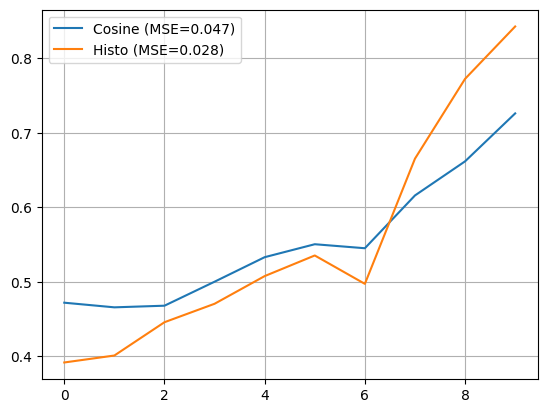

In [106]:
res_avg_rk = pd.DataFrame(res['avg_rk']).T.mean()
res_avg_rk_h = pd.DataFrame(res['avg_rk_h']).T.mean()
res_avg_rk.plot(grid=True, label=f'Cosine (MSE={avg_rk_mse(res_avg_rk):.3f})')
res_avg_rk_h.plot(grid=True, label=f'Histo (MSE={avg_rk_mse(res_avg_rk_h):.3f})')
plt.legend()

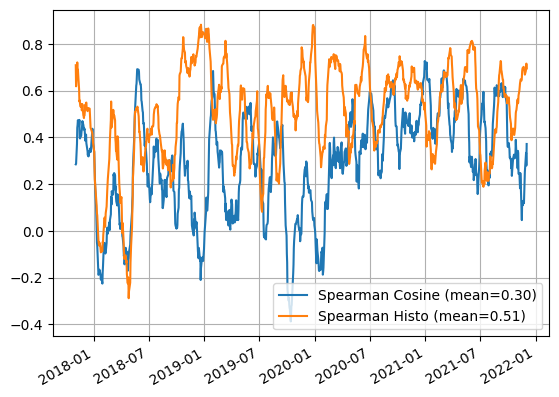

In [107]:
res_spearman = to_sorted_dates_index(pd.DataFrame({'spearman': res['spearman'].values(), 'spearman_h': res['spearman_h'].values()}, index=res['spearman'].keys()))
mean_spearman = res_spearman['spearman'].mean()
mean_spearman_h = res_spearman['spearman_h'].mean()
res_spearman = res_spearman.rolling(window='20D', min_periods=1).mean()
res_spearman['spearman'].plot(label=f'Spearman Cosine (mean={mean_spearman:.2f})')
res_spearman['spearman_h'].plot(label=f'Spearman Histo (mean={mean_spearman_h:.2f})')
plt.legend()
plt.grid()
plt.show()

In [25]:
f_corr_d.round(1)

Ticker,AAPL,AMZN,CVX,JPM,MSFT,TSLA
Ticker,,,,,,
AAPL,1.0,0.7,0.5,0.2,0.9,0.7
AMZN,0.7,1.0,0.2,0.3,0.6,0.6
CVX,0.5,0.2,1.0,0.8,0.4,0.4
JPM,0.2,0.3,0.8,1.0,0.2,0.3
MSFT,0.9,0.6,0.4,0.2,1.0,0.7
TSLA,0.7,0.6,0.4,0.3,0.7,1.0


In [29]:
mask, i_indices, j_indices = filter_top_hst_correl(f_corr_d, r=0.3)
mask

array([ True, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False,  True])

In [27]:
mask

(array([ True, False, False,  True,  True, False, False, False, False,
         True, False, False, False, False,  True]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]),
 array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))

In [32]:
i_indices, j_indices = np.triu_indices(f_corr_d.shape[0], k=1)
print(f_corr_d.to_numpy()[i_indices, j_indices].round(1))
tickers_d = f_corr_d.index.to_numpy()
pd.Series(True, index=np.array(list(zip(tickers_d[i_indices], tickers_d[j_indices])))[mask])

[0.7 0.5 0.2 0.9 0.7 0.2 0.3 0.6 0.6 0.8 0.4 0.4 0.2 0.3 0.7]


(AAPL, AMZN)    True
(AAPL, MSFT)    True
(AAPL, TSLA)    True
(CVX, JPM)      True
(MSFT, TSLA)    True
dtype: bool

In [37]:
np.array(list(zip(i_indices, j_indices)))[mask]

array([[0, 1],
       [0, 4],
       [0, 5],
       [2, 3],
       [4, 5]])

In [49]:
df = pd.DataFrame(np.array(list(zip(i_indices, j_indices)))[mask], index=np.array(list(zip(tickers_d[i_indices], tickers_d[j_indices])))[mask], columns=['idx_i', 'idx_j']).T
display(df)
df.to_dict()

,"(AAPL, AMZN)","(AAPL, MSFT)","(AAPL, TSLA)","(CVX, JPM)","(MSFT, TSLA)"
idx_i,0,0,0,2,4
idx_j,1,4,5,3,5


{('AAPL', 'AMZN'): {'idx_i': 0, 'idx_j': 1},
 ('AAPL', 'MSFT'): {'idx_i': 0, 'idx_j': 4},
 ('AAPL', 'TSLA'): {'idx_i': 0, 'idx_j': 5},
 ('CVX', 'JPM'): {'idx_i': 2, 'idx_j': 3},
 ('MSFT', 'TSLA'): {'idx_i': 4, 'idx_j': 5}}

In [23]:
np.array(list(zip(tickers_d[i_indices], tickers_d[j_indices])))

NameError: name 'tickers_d' is not defined

In [51]:
import pandas as pd
import numpy as np

# Sample data
i_indices = np.array([0, 0, 0, 2, 4])
j_indices = np.array([1, 4, 5, 3, 5])
tickers_d = np.array(['AAPL', 'AMZN', 'MSFT', 'TSLA', 'CVX', 'JPM'])

# Boolean mask
mask = np.array([True, True, True, True, True])

# Applying mask to indices
i_indices = i_indices[mask]
j_indices = j_indices[mask]

# Generating ticker pairs as a list of tuples
pairs = list(zip(tickers_d[i_indices], tickers_d[j_indices]))

# Creating DataFrame
df = pd.DataFrame({
    'idx_i': i_indices,
    'idx_j': j_indices
}, index=pd.MultiIndex.from_tuples(pairs))

# Generating dictionary without loops
result_dict = df.apply(tuple, axis=1).to_dict()

# Display the result
print(result_dict)





{('AAPL', 'AMZN'): (0, 1), ('AAPL', 'CVX'): (0, 4), ('AAPL', 'JPM'): (0, 5), ('MSFT', 'TSLA'): (2, 3), ('CVX', 'JPM'): (4, 5)}


In [19]:
import pandas as pd
import numpy as np

# Example DataFrame and boolean array
boolean = np.array([True, True, False, True, True, True, False, True])
df = pd.DataFrame({
    'col1': ['row_0', 'row_1', 'row_2', 'row_3', 'row_4', 'row_5', 'row_6', 'row_7'],
    'col2': ['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7'],
})

# Initialize list of stacks and current stack
all_stacks = []
current_stack = []

# Iterate through the boolean array and DataFrame rows
for bool_value, row in zip(boolean, df.itertuples(index=False)):
    if bool_value:
        current_stack.append(row)
    else:
        if current_stack:
            all_stacks.append(current_stack)
            current_stack = []

# Add the last stack if it's not empty
if current_stack:
    all_stacks.append(current_stack)

# Convert the stacks back to DataFrames if needed
all_stacks_dfs = [pd.DataFrame(stack) for stack in all_stacks]

# Print the results
for i, stack_df in enumerate(all_stacks_dfs):
    print(f"Stack {i+1}:")
    print(stack_df)
    print()


Stack 1:
    col1 col2
0  row_0   r0
1  row_1   r1

Stack 2:
    col1 col2
0  row_3   r3
1  row_4   r4
2  row_5   r5

Stack 3:
    col1 col2
0  row_7   r7



In [20]:
all_stacks_dfs

[    col1 col2
 0  row_0   r0
 1  row_1   r1,
     col1 col2
 0  row_3   r3
 1  row_4   r4
 2  row_5   r5,
     col1 col2
 0  row_7   r7]

In [174]:
import pandas as pd
import numpy as np

def pair_to_emb_stacks(boolean: np.ndarray, df: pd.DataFrame):
    assert len(boolean) == df.shape[0]
    shifted_boolean = np.roll(boolean, 1)
    shifted_boolean[0] = False
    starts = np.where((boolean == True) & (shifted_boolean == False))[0]
    ends = np.where((boolean == False) & (shifted_boolean == True))[0]
    if boolean[-1]:
        ends = np.append(ends, len(boolean))
    stacks = [df.iloc[start:end] for start, end in zip(starts, ends)]
    return stacks


# Example DataFrame and boolean array
boolean = np.array([True, True, False, True, True, True, False, True])
df = pd.DataFrame({
    'col1': ['row_0', 'row_1', 'row_2', 'row_3', 'row_4', 'row_5', 'row_6', 'row_7'],
    'col2': ['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7'],
})

# Find the start and end indices of contiguous True sequences
shifted_boolean = np.roll(boolean, 1)
shifted_boolean[0] = False  # Correct the first element shift

starts = np.where((boolean == True) & (shifted_boolean == False))[0]
ends = np.where((boolean == False) & (shifted_boolean == True))[0]

# If the last element is True, it means the last stack ends at the end of the array
if boolean[-1]:
    ends = np.append(ends, len(boolean))

# Generate DataFrame stacks
stacks = [df.iloc[start:end] for start, end in zip(starts, ends)]
stacks_2 = pair_to_emb_stacks(boolean, df)

# Print the results
for i, stack in enumerate(stacks):
    print(f"Stack {i+1}:")
    print(stack)
    assert stack.equals(stacks_2[i])
    print()


Stack 1:
    col1 col2
0  row_0   r0
1  row_1   r1

Stack 2:
    col1 col2
3  row_3   r3
4  row_4   r4
5  row_5   r5

Stack 3:
    col1 col2
7  row_7   r7

